
## <center>** Anime recommendations using NLP **


Welcome to this project where we will follow the text mining process to end up by creating a Content Based Recommendation System.So if our user gives us an anime title, our goal is to recommend animes that share similar plot summaries..
So because our goal is to use text mining to create a content based recommendation system, so we will need a textual information about each anime so we find out that the anime description can be a great choice for our case, that is why our dataset will contain two main columns: title and description

`in this project we will follow the following steps:`

* Create a web scraping script which collects data about animes and build our dataset (title, description).
* Clean the dataset and apply NLP techniques and optimize it (by adding new stop words, ...)
* Create the tf-idf matrix which will be used to train our model.
* Apply cosine_similarity algorithms to create our recommendation system.

----------------------------
----------------------------

### <center> `Anime Scraping` 

In this part we will run a web scraping script using the libraries request and BeautifulSoop to collect some information about a list of animes based on a very famous site web in this domain called my anime list (we choose this site web because it is used by people in the whole world so information collected will be more reliable and our algorithms will give better results). 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [3]:
df_final = pd.DataFrame(columns=['title','description'])
for h in range(0,4150,50):
    req = requests.get('https://myanimelist.net/topanime.php',params={'limit':h})
    soup = BeautifulSoup(req.text, 'html.parser')
    animes = soup.find_all('tr')[1:]
    df = pd.DataFrame(columns=['title','description'])
    for anime in animes :
        link = anime.find_all('td')[1].find('a').get('href')
        res = requests.get(link)
        if (res.status_code == 200) :
            s = BeautifulSoup(re.text, 'html.parser')
            try:
                title = s.find('p',{'class':'title-english title-inherit'}).text
            except:
                try: title = s.find('p',{'class':'title-english title-inherit'}).text
                except: 
                    try : title = s.find('h1').text
                    except: title= None
            finally :
                try: description = s.find('p',{"itemprop":"description"}).text
                except: description = None
                df.loc[len(df)] = [title,description]
    print(h)
    df_final=pd.concat([df_final,df],axis=0).reset_index(drop=True)
df_final.to_csv("anime.csv")

0


## **The Dataset**

By the end of this step we have a dataset which contains data on anime listings. It contains the following columns:

- `title`: Or the name of the anime
- `description`: a paragraph which describes the anime

----------------------------
----------------------------

### <center> `Data Cleaning` 

In this part we will first try to understand our dataset then clean it using NLP techniques

In [2]:
df = pd.read_csv('animes.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4150 entries, 0 to 4149
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         4150 non-null   int64  
 1   score        4150 non-null   float64
 2   title        4150 non-null   object 
 3   type         4150 non-null   object 
 4   genres       4150 non-null   object 
 5   episodes     4150 non-null   object 
 6   producers    4150 non-null   object 
 7   trailer      2274 non-null   object 
 8   image        4150 non-null   object 
 9   description  4150 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 356.6+ KB


In [3]:
# first we need to drop some columns
anime = df[['title','description']]
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4150 entries, 0 to 4149
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4150 non-null   object
 1   description  4150 non-null   object
dtypes: object(2)
memory usage: 97.3+ KB


In [8]:
anime.head()

,title,description
0,Bleach: Thousand-Year Blood War,Substitute Soul Reaper Ichigo Kurosaki spends ...
1,Fullmetal Alchemist: Brotherhood,After a horrific alchemy experiment goes wrong...
2,Steins;Gate,Eccentric scientist Rintarou Okabe has a never...
3,Gintama Season 4,"Gintoki, Shinpachi, and Kagura return as the f..."
4,Kaguya-sama: Love is War - Ultra Romantic,The elite members of Shuchiin Academy's studen...


## **Our to do list:**


- **`Task 1`**: Dealing with duplicates and missing values

- **`Task 2`**: NLP_preprocessing

- **`Task 3`**:  Term Frequency and Inverse Document Frequency


### `Dealing with missing values and duplicates`

In [4]:
# find duplicates
anime[anime.duplicated()]

,title,description
1500,Moyashimon,One could say that freshman college student Ta...
1501,Recovery of an MMO Junkie,For the first time since graduating high schoo...


In [5]:
# find if the rank column has some duplicates because this variable must be unique for each anime 
anime.drop_duplicates(inplace=True)

C:\Users\a\AppData\Local\Temp\ipykernel_7000\2100976177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime.drop_duplicates(inplace=True)


In [6]:
anime.duplicated().sum()

0

In [7]:
# fortunutly we don't have missing values in our dataset
anime.isna().sum()

title          0
description    0
dtype: int64

In [8]:
anime.reset_index(inplace=True) 

### `NLP_preprocessing :` 
- Lower casing
- Punctuation removal
- Contractions: We don't have to worry about this because descriptions are written by specialist in the anime domain so
                they will use a correct language    
- Identifying and Remove Stop Words
- Tokenize Text in Words
- Lemmatize words
- remove extra spaces
- Generate a word cloud image
- update the list of stop words to ameliorate the model

In [10]:
anime['description'].head(1)[0]

"substitute soul reaper ichigo kurosaki spends his days fighting against hollows, dangerous evil spirits that threaten karakura town. ichigo carries out his quest with his closest allies: orihime inoue, his childhood friend with a talent for healing; yasutora sado, his high school classmate with superhuman strength; and uryuu ishida, ichigo's quincy rival.\n\r\nichigo's vigilante routine is disrupted by the sudden appearance of asguiaro ebern, a dangerous arrancar who heralds the return of yhwach, an ancient quincy king. yhwach seeks to reignite the historic blood feud between soul reaper and quincy, and he sets his sights on erasing both the human world and the soul society for good.\n\r\nyhwach launches a two-pronged invasion into both the soul society and hueco mundo, the home of hollows and arrancar. in retaliation, ichigo and his friends must fight alongside old allies and enemies alike to end yhwach's campaign of carnage before the world itself comes to an end.\n\r\n[written by m

In [9]:
##lower case
anime["description"]=anime["description"].str.lower()

C:\Users\a\AppData\Local\Temp\ipykernel_7000\2317012142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime["description"]=anime["description"].str.lower()


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string


# Download stopwords and lemmatizer data and punkt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def NLP_preprocess(text):
    
    # Punctuation removal
    text = re.sub('[%s]' % re.escape(string.punctuation), '' , text)
    
    #remove words with digits 
    text = re.sub(r'[0-9]*', '',text)
   
    # Tokenize text into words
    tokens = word_tokenize(text)

    # Remove stopwords
    additional_stopwords  = ["new",'become','rewrite',"day",'story','take','even','hing','well','although','episode'
                            ,'named',"rewirte",'mal','must','first','write','ann','written','one','two']
    stop_words = set(stopwords.words('english'))
    stop_words.update(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    # remove extra spaces
    preprocessed_text = re.sub(' +', ' ', preprocessed_text)
    
    return preprocessed_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
anime["after_nlp"]=anime["description"].apply(NLP_preprocess)

C:\Users\a\AppData\Local\Temp\ipykernel_7000\4123253471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime["after_nlp"]=anime["after_nlp"].apply(NLP_preprocess)


(-0.5, 799.5, 599.5, -0.5)

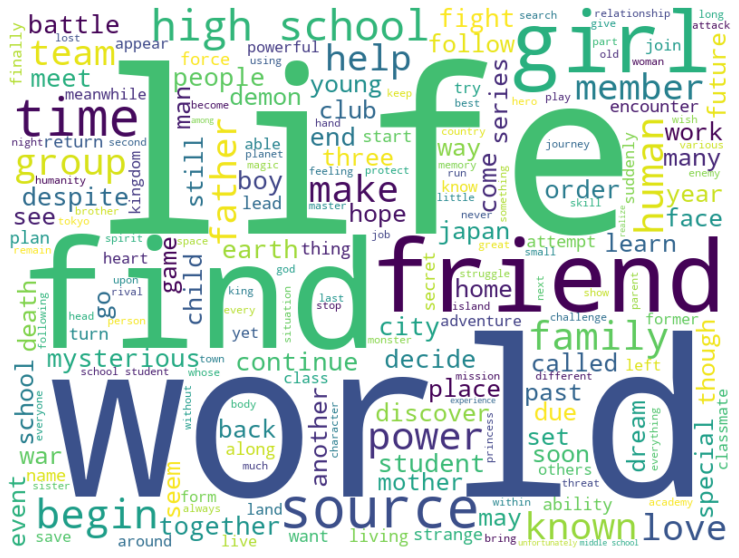

In [14]:
import matplotlib
import pylab as plt

from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(anime['after_nlp']))
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### `Term Frequency and Inverse Document Frequency`

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
print('Tfidf ponderations')

# Initialize the "TfidfVectorizer" object.
tfidf_vect = TfidfVectorizer(  
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 1),
            stop_words = 'english')

X_tfidf = tfidf_vect.fit_transform(anime['after_nlp'])

# Numpy arrays are easy to work with, so convert the result to an array
vectorizer_features = X_tfidf.toarray()
tfidf_frequency_matrix = pd.DataFrame(vectorizer_features,columns=tfidf_vect.get_feature_names_out())
tfidf_frequency_matrix


Tfidf ponderations


,1,2,aa,aaron,aasu,aback,abandon,abandoned,abandoning,abarai,...,リルル,夏のわすらい,始まりのセン,愛里寿,木々,永倉新八最強伝説,白雪とセン,秋山優花里の戦車講座,鶺鴒余暇,鶺鴒診断
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
---
### <center> `anime recommendations algorithm`

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine similarity
cosine_sim = cosine_similarity(X_tfidf)

# function to get recommendations
def anime_recommendations(title, cosine_sim=cosine_sim, anime_df=anime):
    # get index of the anime title
    idx = anime_df[anime_df['title'] == title].index[0]
    
    # get the cosine similarity scores for all anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort the anime based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the top 10 most similar anime
    sim_scores = sim_scores[1:11]
    
    # get the anime indices
    anime_indices = [i[0] for i in sim_scores]
    
    # return the top 10 most similar anime
    return anime_df['title'].iloc[anime_indices]


In [17]:
anime_recommendations('One Piece')

768     One Piece: Episode of East Blue - Luffy and Hi...
304                          One Piece Movie 14: Stampede
399                                      One Piece Film Z
2354                        One Piece: Romance Dawn Story
639                One Piece Film: Strong World Episode 0
2988    One Piece Special: Open Upon the Great Sea! A ...
1050      One Piece: Baron Omatsuri and the Secret Island
464                          One Piece Film: Strong World
3650                                   One Piece Movie 01
2422                One Piece: Mamore! Saigo no Dai Butai
Name: title, dtype: object

In [18]:
anime_recommendations('Haikyu!! 3rd Season')

372             Haikyu!! The Movie: Battle of Concepts
97                        Haikyu!! TO THE TOP 2nd-cour
554      Haikyuu!! the Movie: The Winner and the Loser
69                                 Haikyu!! 2nd Season
592      Haikyu!! the Movie: The End and the Beginning
196                                Haikyu!! To the Top
280                              Ace of Diamond Act II
718    Prince of Tennis: National Championship Chapter
237                      Ace of Diamond: Second Season
424               Haikyu!! The Movie: Talent and Sense
Name: title, dtype: object

In [19]:
anime_recommendations('Slam Dunk')

1548    Slam Dunk: Shouhoku Saidai no Kiki! Moero Saku...
239                                 Kuroko's Basketball 3
2630                                        Ahiru no Sora
2365                                    Slam Dunk (Movie)
3896                                             Roujin Z
1272    Slam Dunk: Hoero Basketman-damashii! Hanamichi...
2204               Hiyoko no Basket Movie: Last Game 0401
1128    Winter Cup Highlights Episode 1 – Winter Cup H...
497                                   Kuroko's Basketball
315                                 Kuroko's Basketball 2
Name: title, dtype: object

In [20]:
anime_recommendations('Fullmetal Alchemist: Brotherhood')

428                                   Fullmetal Alchemist
1668    Fullmetal Alchemist: The Movie - Conqueror of ...
2704        Fullmetal Alchemist: The Sacred Star of Milos
583       Fullmetal Alchemist: Brotherhood OVA Collection
3758                                       Ronin Warriors
2486          Fullmetal Alchemist: Premium OVA Collection
3134    Donten: Laughing Under the Clouds - Gaiden: Ch...
3416                                GARO -VANISHING LINE-
172                                  Land of the Lustrous
2208                                 Kaze no Shoujo Emily
Name: title, dtype: object